In [6]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
!pip install pandas nltk transformers matplotlib pyspark emoji textblob openpyxl
!pip install langid
!pip install pyspark


In [8]:
from pyspark.sql import SparkSession
# Crear SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Leer el archivo CSV
data = spark.read.csv('comentarios_espanol.csv', header=True, sep=",")
data.show(10)

+--------------------+
|     Cleaned_Comment|
+--------------------+
|         Los amo😍😍|
|             Los amo|
|No puedo con tant...|
|        Los amo!! ♥️|
|Está pequeña part...|
|No puedo con tant...|
|No puedo con tant...|
|Piel de gallina.....|
|No puedo con tant...|
|Es simplemente he...|
+--------------------+
only showing top 10 rows



In [31]:
from pyspark.sql.functions import col

# Aplicar UDFs al DataFrame
df = df.withColumn("sentimiento_bert", analizar_sentimiento_bert_udf(col("Cleaned_Comment")))

df.show()

+--------------------+------+----------------+
|     Cleaned_Comment|emojis|sentimiento_bert|
+--------------------+------+----------------+
|         Los amo😍😍|  😍😍|         5 stars|
|             Los amo|      |         5 stars|
|No puedo con tant...|     ❤|         5 stars|
|        Los amo!! ♥️|    ♥️|         5 stars|
|Está pequeña part...|    ❤️|         5 stars|
|No puedo con tant...|     ❤|         5 stars|
|No puedo con tant...|     ❤|         5 stars|
|Piel de gallina.....|    🙌|         5 stars|
|No puedo con tant...|     ❤|         5 stars|
|Es simplemente he...|      |         5 stars|
|Que placer ser pa...|      |         5 stars|
|Bellísima, muy em...|      |         5 stars|
|Muito obrigado Be...|    ♥️|         5 stars|
|    LOS AMOOOOOOOOOO|      |         3 stars|
|           Eternos ❤|     ❤|         5 stars|
|El solo con slide...|      |         5 stars|
|             Los amo|      |         5 stars|
|           Los amo❤️|    ❤️|         5 stars|
|Que sería de mi v

In [19]:
import re
#Definimos el modelo
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Definir una función para clasificar el sentimiento
def get_sentiment(text):
    # Clasificamos la frase
    result = classifier(text)[0]
    score = int(result['label'][0])
    # Interpretamos el resultado
    if score < 3:
        sentiment = 'Negativo'
    elif score == 3:
        sentiment = 'Neutral'
    else:
        sentiment = 'Positivo'
    return sentiment


def clean_text3(Comment):
  text = re.sub(r'^RT[\s]+', '', Comment)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', Comment)
  text = re.sub(r'#', '', Comment)
  text = re.sub(r'@[A-Za-z0-9]+', '', Comment)
  return text



In [21]:
# Aplicar la función para extraer emojis a cada comentario
df_pandas['emojis'] = df_pandas['Cleaned_Comment'].apply(extraer_emojis)

# Crear un DataFrame solo con los comentarios y los emojis extraídos
df_emojis = df_pandas[['Cleaned_Comment', 'emojis']]

# Filtrar para mostrar solo filas donde se encontraron emojis
df_emojis = df_emojis[df_emojis['emojis'].str.len() > 0]

# Mostrar el DataFrame resultante
print(df_emojis)

                                      Cleaned_Comment emojis
0                                           Los amo😍😍     😍😍
2                    No puedo con tanta felicidad ❤‍🩹      ❤
3                                        Los amo!! ♥️     ♥️
4   Está pequeña parte de mi vida se llama felicid...     ❤️
5                    No puedo con tanta felicidad ❤‍🩹      ❤
6                    No puedo con tanta felicidad ❤‍🩹      ❤
7                 Piel de gallina... 🙌 Emoción pura!!      🙌
8                    No puedo con tanta felicidad ❤‍🩹      ❤
12  Muito obrigado Beatles por terem existido, I m...     ♥️
14                                          Eternos ❤      ❤
17                                          Los amo❤️     ❤️
19                                          los amo 😭      😭
20                                          los amo 😭      😭
21                        Los amo mucho demasiado ❤️🥹     ❤️
25  Gran gran canción, interesante como se escucha...     ❤️


In [3]:
import pandas as pd
data = pd.read_csv('comentarios_espanol.csv', sep=';', encoding='latin1')
data

# Añadir una nueva columna al DataFrame con el sentimiento
data['Sentimiento'] = data['Cleaned_Comment'].apply(get_sentiment)
data

,Cleaned_Comment,Sentimiento
0,Los amoðð,Negativo
1,Los amo,Positivo
2,No puedo con tanta felicidad â¤âð©¹,Negativo
3,Los amo!! â¥ï¸,Positivo
4,EstÃ¡ pequeÃ±a parte de mi vida se llama felic...,Positivo
5,No puedo con tanta felicidad â¤âð©¹,Negativo
6,No puedo con tanta felicidad â¤âð©¹,Negativo
7,Piel de gallina... ð EmociÃ³n pura!!,Positivo
8,No puedo con tanta felicidad â¤âð©¹,Negativo
9,Es simplemente hermoso <3 valiÃ³ la pena esper...,Positivo


In [22]:
# Crear una lista con todos los emojis
lista_emojis = ' '.join(df_emojis['emojis']).split()

In [24]:
from collections import Counter

# Contar la frecuencia de cada emoji
conteo_emojis = Counter(lista_emojis)

In [25]:
# Convertir el DataFrame de Pandas a un DataFrame de Spark
df = spark.createDataFrame(df_pandas)

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Cargar el modelo BERT para español
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
# Función para análisis de sentimientos con NLTK
def analizar_sentimiento_nltk(texto):
    sia = SentimentIntensityAnalyzer()
    texto_modificado = texto.replace("ja", "feliz").replace("XD", "alegre")
    puntaje = sia.polarity_scores(texto_modificado)
    return 'positivo' if puntaje['compound'] > 0.05 else ('negativo' if puntaje['compound'] < -0.05 else 'neutro')
# Función para análisis de sentimientos con BERT
def analizar_sentimiento_bert(texto):
    resultado = sentiment_pipeline(texto)[0]
    return resultado['label']
# UDFs para Spark
analizar_sentimiento_bert_udf = udf(analizar_sentimiento_bert, StringType())

In [32]:
# Convertir a DataFrame de Pandas para facilitar la visualización
df_pandas = df.toPandas()

In [33]:
# Contar sentimientos para NLTK y BERT
sentimientos_bert = df_pandas['sentimiento_bert'].value_counts()

In [35]:
import matplotlib.pyplot as plt
# Crear gráficos de barras
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [9]:
# Leer el archivo CSV
data = spark.read.csv('comentarios_espanol.csv', header=True, sep=",")
data.show(10)

+--------------------+
|     Cleaned_Comment|
+--------------------+
|         Los amo😍😍|
|             Los amo|
|No puedo con tant...|
|        Los amo!! ♥️|
|Está pequeña part...|
|No puedo con tant...|
|No puedo con tant...|
|Piel de gallina.....|
|No puedo con tant...|
|Es simplemente he...|
+--------------------+
only showing top 10 rows



In [14]:
import pandas as pd

# Leer el archivo CSV en un DataFrame de pandas
df_pandas = pd.read_csv('comentarios_espanol.csv')


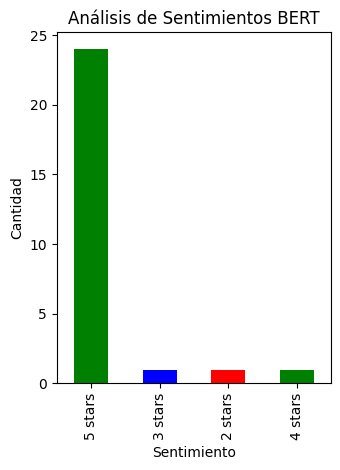

In [43]:
# Gráfico para BERT
plt.subplot(1, 2, 2)
sentimientos_bert.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Análisis de Sentimientos BERT')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')


plt.tight_layout()
plt.show()

In [39]:
from transformers import BertTokenizer

model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

texto = input("Ingrese una oración para el análisis de sentimiento: ")

Ingrese una oración para el análisis de sentimiento:  Los amo😍😍
